# **Chapter 7. Secular Perturbations**

## **Action by Daniel Niño-Villegas, University of Antioquia**

In this notebook we will present part of the theoretical background of the chapter devoted to *Secular Perturbations* and some mathematical and numerical results which are interested for the theory.

For details on the theory please refer directly to the book:

> Murray, C. D., & Dermott, S. F. (1999). Solar system dynamics. Cambridge university press.

## Preliminaries

### Prerrequisites

In [1]:
#!pip install -q rebound

### Other libraries

In [2]:
#Global packages
import numpy as np
import matplotlib.pyplot as plt
import rebound as rb

#Specific modules and routines
from tqdm import tqdm
from scipy.integrate import quad
from scipy.signal import savgol_filter
from ipywidgets import interact, widgets
from fractions import Fraction

### Useful constants

In [3]:
deg = np.pi/180
rad = 1/deg

### Plots esthetic

In [4]:
%matplotlib nbagg
#If you run this in Colab use
#%matplotlib inline

plt.rcParams['text.usetex'] = True
#If you don't have installed latex
#font for matplotlib, set this parameter
#to false. If you run this in Colab, set
#this parameter to false.

## **Section 6.9.1    Secular Terms**

### Experiment: asteroid orbit perturbation due to Jupiter (6.1)

Let's supose we have a little asteroid orbiting sun and that we want to analyse how it's orbital elements are disturbed due to Jupiter's influence. We'll first make a numerical simulation using *Rebound* to see how orbital elements vary with time and then we'll compare this results with the theory that was developed in chapter 6. Initial conditions are described with detail in chapter 6.9.1, and a diagram of the situation can be seen in figure (?):

Firts, let's create the solar system with the Sun, Jupiter and the asteroid (whose mass doesn't care):

In [5]:
#Jupiter orbital elements
a_p = 5.204267
alpha = 0.192
e_p = 0.048

#Initial conditions
a0 = alpha*a_p
e0 = 0.1
Omega0 = 200*deg
pomega0 = 130*deg
lambda0 = 300*deg
inc_0 = 1e-4*deg

#Masses
m_p = 1/1047.355
m = 1e-17

#System creation
sim = rb.Simulation()
sim.units = ('au', 'msun', 'yr')
sim.add('Sun', hash='Sun')
sim.add(m=m_p, a=a_p, e=e_p, hash='Jupiter')
sim.add(m=m, a=a0, e=e0, inc=inc_0, 
        Omega=Omega0, pomega=pomega0, l=lambda0, hash='Asteroid')
sim.save('tmp/system.bin')

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 


Let's see a plot of the the system in $t=0$:

<IPython.core.display.Javascript object>


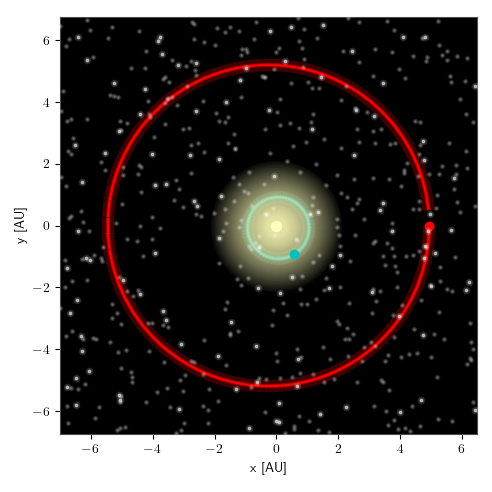

In [6]:
fig, ax = rb.OrbitPlot(sim, unitlabel='[AU]', orbit_type='solid', lw=1.5, color=True, fancy=True)
fig.set_dpi(100)
fig.tight_layout()
#plt.savefig('figs/init_orbit.png', dpi=200, bbox_inches='tight')
plt.show()

Now we'll calcultate the asteorid and Jupiter's periods who are very useful:

In [7]:
#Orbital periods
Pjup = sim.particles['Jupiter'].P
njup = 2*np.pi/Pjup
Past = sim.particles['Asteroid'].P
nast = 2*np.pi/Past

#Gravitational constant
G = sim.G

The time step for integration will be a fraction of the asteroid's initial period, and the total integration time will be 20000 Jupiter periods:

In [8]:
#Integration parameters
sim.dt = Past/100
Nt = 1000
ts = np.linspace(0, 20000*Pjup, Nt)

Now let's do the integration (remember to be a little patient):

In [9]:
#Integration
Es = np.zeros((Nt,4))
for i,t in enumerate(tqdm(ts, position=0, leave=True)):
    sim.integrate(t)
    sim.move_to_hel()
    orbits = sim.calculate_orbits()
    Es[i] = [
        orbits[1].a,
             orbits[1].e,
             np.mod(orbits[1].pomega,2*np.pi),
             np.mod(orbits[1].Omega,2*np.pi)]

100%|█████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.10it/s]


With the simulation done, let's plot $a, e, \varpi$ and $\Omega$ as a function of time:

<IPython.core.display.Javascript object>


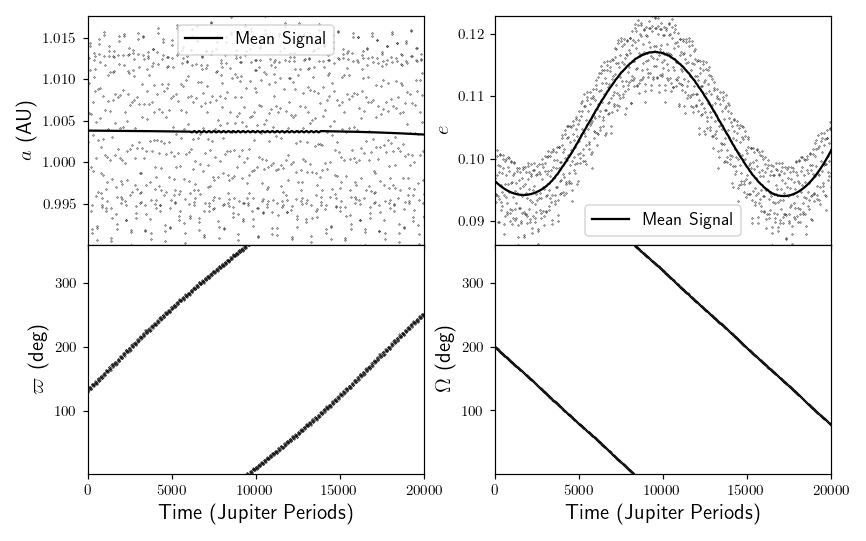

In [10]:
#Filter for semimajor axis mean signal
afilt = savgol_filter(Es[:,0], 611, 2)

#Filter for excentricity mean signal
efilt = savgol_filter(Es[:,1], 311, 2)

#Plots
fig, axs = plt.subplots(2, 2, figsize=(8,5), sharex=True, dpi=110)
ax = fig.gca()
ax.set_xlabel('Time (Jupiter Periods)', fontsize=14)
axs[0,0].plot(ts/Pjup, Es[:,0], 'ko', ms=0.3)
axs[0,0].plot(ts/Pjup, afilt, 'k-', ms=0.3, label='Mean Signal')
axs[0,0].set_ylabel(r'$a$ (AU)', fontsize=14)
axs[0,0].legend(fontsize=12)
axs[0,0].margins(0)
axs[0,1].plot(ts/Pjup, Es[:,1], 'ko', ms=0.3);
axs[0,1].plot(ts/Pjup, efilt, 'k-', ms=0.3, label='Mean Signal')
axs[0,1].set_ylabel(r'$e$', fontsize=14)
axs[0,1].legend(fontsize=12)
axs[0,1].margins(0)
axs[1,0].plot(ts/Pjup, Es[:,2]*rad, 'ko', ms=0.3)
axs[1,0].set_xlabel('Time (Jupiter Periods)', fontsize=14)
axs[1,0].set_ylabel(r'$\varpi$ (deg)', fontsize=14);
axs[1,0].margins(0)
axs[1,1].plot(ts/Pjup, Es[:,3]*rad, 'ko', ms=0.3)
axs[1,1].set_xlabel('Time (Jupiter Periods)', fontsize=14)
axs[1,1].set_ylabel(r'$\Omega$ (deg)', fontsize=14)
axs[1,1].margins(0)
fig.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.21)
#plt.savefig('figs/orbital_elements.png',dpi=300)
plt.show()

As we see in the figure above, the orbital elements vary with time in very particular ways, so now we'll focus on how the theory can describe these behaviours using the results obtained in section 6. First of all, let's rember the series expansion to second order of the direct and indirect parts in the disturbing function of the perturbed object:


\begin{equation*}
\begin{aligned}
\mathcal{R}_{\mathrm{D}}= & \,\left(\frac{1}{2} b_{\frac{1}{2}}^{(j)}+\frac{1}{8}\left(e^2+e^{\prime 2}\right)\left[-4 j^2+2 \alpha D+\alpha^2 D^2\right] b_{\frac{1}{2}}^{(j)}\right. \\
& \left.+\frac{1}{4}\left(s^2+s^{\prime 2}\right)\left([-\alpha] b_{\frac{3}{2}}^{(j-1)}+[-\alpha] b_{\frac{3}{2}}^{(j+1)}\right)\right) \\
& \times \cos \left[j \lambda^{\prime}-j \lambda\right] \\
+ & \left(\frac{1}{4} e e^{\prime}\left[2+6 j+4 j^2-2 \alpha D-\alpha^2 D^2\right] b_{\frac{1}{2}}^{(j+1)}\right) \\
& \times \cos \left[j \lambda^{\prime}-j \lambda+\varpi^{\prime}-\varpi\right] \\
+ & \left(s s^{\prime}[\alpha] b_{\frac{3}{2}}^{(j+1)}\right) \cos \left[j \lambda^{\prime}-j \lambda+\Omega^{\prime}-\Omega\right] \\
+ & \left(\frac{1}{2} e[-2 j-\alpha D] b_{\frac{1}{2}}^{(j)}\right) \cos \left[j \lambda^{\prime}+(1-j) \lambda-\varpi\right] \\
+ & \left(\frac{1}{2} e^{\prime}[-1+2 j+\alpha D] b_{\frac{1}{2}}^{(j-1)}\right) \cos \left[j \lambda^{\prime}+(1-j) \lambda-\varpi^{\prime}\right] \\
+ & \left(\frac{1}{8} e^2\left[-5 j+4 j^2-2 \alpha D+4 j \alpha D+\alpha^2 D^2\right] b_{\frac{1}{2}}^{(j)}\right) \\
& \times \cos \left[j \lambda^{\prime}+(2-j) \lambda-2 \varpi\right] \\
+ & \left(\frac{1}{4} e e^{\prime}\left[-2+6 j-4 j^2+2 \alpha D-4 j \alpha D-\alpha^2 D^2\right] b_{\frac{1}{2}}^{(j-1)}\right) \\
& \times \cos \left[j \lambda^{\prime}+(2-j) \lambda-\varpi^{\prime}-\varpi\right] \\
+ & \left(\frac{1}{8} e^{\prime 2}\left[2-7 j+4 j^2-2 \alpha D+4 j \alpha D+\alpha^2 D^2\right] b_{\frac{1}{2}}^{(j-2)}\right) \\
& \times \cos \left[j \lambda^{\prime}+(2-j) \lambda-2 \varpi^{\prime}\right] \\
+ & \left(\frac{1}{2} s^2[\alpha] b_{\frac{3}{2}}^{(j-1)}\right) \\
& \times \cos \left[j \lambda^{\prime}+(2-j) \lambda-2 \Omega\right] \\
+ & \left(s s^{\prime}[-\alpha] b_{\frac{3}{2}}^{(j-1)}\right) \cos \left[j \lambda^{\prime}+(2-j) \lambda-\Omega^{\prime}-\Omega\right] \\
+ & \left(\frac{1}{2} s^{\prime 2}[\alpha] b_{\frac{3}{2}}^{(j-1)}\right) \cos \left[j \lambda^{\prime}+(2-j) \lambda-2 \Omega^{\prime}\right]
\end{aligned}
\label{eq:dist_func_dir}\tag{1}
\end{equation*}

\begin{equation*}
\begin{aligned}
\mathcal{R}_{\mathrm{E}}= & -\frac{r}{a}\left(\frac{a^{\prime}}{r^{\prime}}\right)^2 \cos \psi \\
\approx & \left(-1+\frac{1}{2} e^2+\frac{1}{2} e^{\prime 2}+s^2+s^{\prime 2}\right) \cos \left[\lambda^{\prime}-\lambda\right] \\
& -e e^{\prime} \cos \left[2 \lambda^{\prime}-2 \lambda-\varpi^{\prime}+\varpi\right]-2 s s^{\prime} \cos \left[\lambda^{\prime}-\lambda-\Omega^{\prime}+\Omega\right] \\
& -\frac{1}{2} e \cos \left[\lambda^{\prime}-2 \lambda+\varpi\right]+\frac{3}{2} e \cos \left[\lambda^{\prime}-\varpi\right]-2 e^{\prime} \cos \left[2 \lambda^{\prime}-\lambda-\varpi^{\prime}\right] \\
& -\frac{3}{8} e^2 \cos \left[\lambda^{\prime}-3 \lambda+2 \varpi\right]-\frac{1}{8} e^2 \cos \left[\lambda^{\prime}+\lambda-2 \varpi\right] \\
& +3 e e^{\prime} \cos \left[2 \lambda-\varpi^{\prime}-\varpi\right]-\frac{1}{8} e^{\prime 2} \cos \left[\lambda^{\prime}+\lambda-2 \varpi^{\prime}\right] \\
& -\frac{27}{8} e^{\prime 2} \cos \left[3 \lambda^{\prime}-\lambda-2 \varpi^{\prime}\right]-s^2 \cos \left[\lambda^{\prime}+\lambda-2 \Omega\right] \\
& +2 s s^{\prime} \cos \left[\lambda^{\prime}+\lambda-\Omega^{\prime}-\Omega\right]-s^{\prime 2} \cos \left[\lambda^{\prime}+\lambda-2 \Omega^{\prime}\right]
\end{aligned}
\label{eq:dist_func_indir}\tag{2}
\end{equation*}

If we want to describe the secular behaviour of the perturbations we then only consider the secular terms in both expansions, that is, the terms who do not contain the mean longitudes $\lambda$ and $\lambda'$. This simplification is done because the mean longitudes are proportional to the time ($\lambda = nt + \epsilon$), so they will have little period oscillations that for secular purposes are not needed. Secular terms in the direct part are then obtained by setting $j = 0$ in the cosine arguments containing $j\lambda - j\lambda$, and discarding the remaing terms who depend on $\lambda$ or $\lambda'$:

\begin{equation*}
\begin{aligned}
\left\langle\mathcal{R}_{\mathrm{D}}\right\rangle = & \,\left(\frac{1}{2} b_{\frac{1}{2}}^{(0)}+\frac{1}{8}\left(e^2+e^{\prime 2}\right)\left[2 \alpha D+\alpha^2 D^2\right] b_{\frac{1}{2}}^{(0)}\right. \\
& \left.+\frac{1}{4} s^2\left([-\alpha] b_{\frac{3}{2}}^{(-1)}+[-\alpha] b_{\frac{3}{2}}^{(1)}\right)\right) \\
+ & \left(\frac{1}{4} e e^{\prime}\left[2-2 \alpha D-\alpha^2 D^2\right] b_{\frac{1}{2}}^{(1)}\right) \\
& \times \cos \left[\varpi^{\prime}-\varpi\right] \\
\end{aligned}
\tag{3}
\end{equation*}

It was used that Jupiter's orbital plane is the reference plane, so $s' = 0$. Using $b_{\frac{3}{2}}^{(-1)} = b_{\frac{3}{2}}^{(1)}$:

\begin{equation*}
\begin{aligned}
\left\langle\mathcal{R}_{\mathrm{D}}\right\rangle = & \, \frac{1}{2} b_{\frac{1}{2}}^{(0)} + \frac{1}{8}\left(e^2+e^{\prime 2}\right)\left[2 \alpha D+\alpha^2 D^2\right] b_{\frac{1}{2}}^{(0)} - \frac{1}{2} \alpha b_{\frac{3}{2}}^{(1)} s^2 \\
+ & \left(\frac{1}{4} e e^{\prime}\left[2-2 \alpha D-\alpha^2 D^2\right] b_{\frac{1}{2}}^{(1)}\right) \cos \left[\varpi^{\prime}-\varpi\right] \\
\end{aligned}
\tag{3}
\end{equation*}

This result can be condensed as:

\begin{equation*}
\left\langle\mathcal{R}_{\mathrm{D}}\right\rangle = C_0+C_1\left(e^2+e^{\prime 2}\right)+C_2 s^2+C_3 e e^{\prime} \cos \left(\varpi^{\prime}-\varpi\right)
\label{eq:mean_RD}\tag{4}
\end{equation*}

Where:

\begin{equation*}
\begin{aligned}
C_0 & =\frac{1}{2} b_{\frac{1}{2}}^{(0)}(\alpha) \\ 
C_1 & =\frac{1}{8}\left[2 \alpha D+\alpha^2 D^2\right] b_{\frac{1}{2}}^{(0)}(\alpha) \\
C_2 & =-\frac{1}{2} \alpha b_{\frac{3}{2}}^{(1)}(\alpha) \\
C_3 & =\frac{1}{4}\left[2-2 \alpha D-\alpha^2 D^2\right] b_{\frac{1}{2}}^{(1)}(\alpha) 
\end{aligned}
\label{eq:dist_coeff}\tag{5}
\end{equation*}

If we check the indirect part in Eq. \eqref{eq:dist_func_indir} we see that all terms depend on $\lambda$ and $\lambda'$, so there are no secular contributions from this part to the disturbing function. That is:

\begin{equation*}
\left\langle\mathcal{R}_{\mathrm{E}}\right\rangle = 0
\label{eq:mean_RE}\tag{6}
\end{equation*}

Now, using Eq. \eqref{eq:mean_RD} and Eq. \eqref{eq:mean_RE} we find out that:

\begin{equation*}
\left\langle R \right\rangle = \frac{\mu'}{a'} \left( C_0+C_1\left(e^2+e^{\prime 2}\right)+C_2 s^2+C_3 e e^{\prime} \cos \left(\varpi^{\prime}-\varpi\right) \right) 
\tag{7}\label{eq:mean_dist}
\end{equation*}

Now we've found the expression for the (mean) disturbing function, we need to use the *Lagrange planetary equations* to find the osculating orbital elements as a function of time. The equations are shown below:

\begin{equation*}
\begin{aligned}
\frac{\mathrm{d} a}{\mathrm{~d} t} &=\frac{2}{n a} \frac{\partial \mathcal{R}}{\partial \epsilon} \\
\frac{\mathrm{d} e}{\mathrm{~d} t} &=-\frac{\sqrt{1-e^2}}{n a^2 e}\left(1-\sqrt{1-e^2}\right) \frac{\partial \mathcal{R}}{\partial \epsilon}-\frac{\sqrt{1-e^2}}{n a^2 e} \frac{\partial \mathcal{R}}{\partial \varpi} \\
\frac{\mathrm{d} \epsilon}{\mathrm{d} t} & =-\frac{2}{n a} \frac{\partial R}{\partial a}+\frac{\sqrt{1-e^2}\left(1-\sqrt{1-e^2}\right)}{n a^2 e} \frac{\partial \mathcal{R}}{\partial e}+\frac{\tan \frac{1}{2} I}{n a^2 \sqrt{1-e^2}} \frac{\partial \mathcal{R}}{\partial I} \\
\frac{\mathrm{d} \Omega}{\mathrm{d} t} & =\frac{1}{n a^2 \sqrt{1-e^2} \sin I} \frac{\partial \mathcal{R}}{\partial I} \\
\frac{\mathrm{d} \varpi}{\mathrm{d} t} & =\frac{\sqrt{1-e^2}}{n a^2 e} \frac{\partial \mathcal{R}}{\partial e}+\frac{\tan \frac{1}{2} I}{n a^2 \sqrt{1-e^2}} \frac{\partial \mathcal{R}}{\partial I} \\
\frac{\mathrm{d} I}{\mathrm{~d} t} & =\frac{-\tan \frac{1}{2} I}{n a^2 \sqrt{1-e^2}}\left(\frac{\partial \mathcal{R}}{\partial \epsilon}+\frac{\partial \mathcal{R}}{\partial \varpi}\right)-\frac{1}{n a^2 \sqrt{1-e^2} \sin I} \frac{\partial \mathcal{R}}{\partial \Omega} .
\end{aligned}
\tag{8}
\end{equation*}

Where we've introduced the $\epsilon$ variable, who's defined as:

\begin{equation*}
\begin{aligned}
\lambda & = M + \varpi \\ 
& = n(t-\tau) + \varpi \\
& = nt + (\varpi - n\tau) \\
& = nt + \epsilon \\
\end{aligned}
\end{equation*}

\begin{equation*}
\therefore \epsilon \equiv \varpi - n\tau
\tag{9}
\end{equation*}

If we suppose that $e \ll 1$ and $I \ll 1$, the Lagrange equations reduce to:

\begin{equation*}
\begin{aligned}
\frac{\mathrm{d} a}{\mathrm{d} t} & =\frac{2}{n a} \frac{\partial\langle\mathcal{R}\rangle}{\partial \lambda} \\
\frac{\mathrm{d} e}{\mathrm{d} t} & =-\frac{1}{n a^2 e} \frac{\partial\langle\mathcal{R}\rangle}{\partial \varpi} \\
\frac{\mathrm{d} \varpi}{\mathrm{d} t} & =+\frac{1}{n a^2 e} \frac{\partial\langle\mathcal{R}\rangle}{\partial e} \\
\frac{\mathrm{d} \Omega}{\mathrm{d} t} & =+\frac{1}{n a^2 \sin I} \frac{\partial\langle\mathcal{R}\rangle}{\partial I}
\end{aligned}
\label{eq:red_lagrange}\tag{10}
\end{equation*}

Introducing Eq. \eqref{eq:mean_dist} in Eqs. \eqref{eq:red_lagrange} and remembering that $n^2 a^3 \approx G m_c$ we found the next set of differential equations:

\begin{equation*}
\begin{aligned}
\left(\frac{\mathrm{d} a}{\mathrm{~d} t}\right)_{\mathrm{sec}} & =0 \\
\left(\frac{\mathrm{d} e}{\mathrm{~d} t}\right)_{\mathrm{sec}} & =n \alpha\left(m^{\prime} / m_{\mathrm{c}}\right) C_3 e^{\prime} \sin \left(\varpi-\varpi^{\prime}\right) \\
\left(\frac{\mathrm{d} \varpi}{\mathrm{d} t}\right)_{\mathrm{sec}} & =n \alpha\left(m^{\prime} / m_{\mathrm{c}}\right)\left[2 C_1+C_3\left(e^{\prime} / e\right) \cos \left(\varpi-\varpi^{\prime}\right)\right] \\
\left(\frac{\mathrm{d} \Omega}{\mathrm{d} t}\right)_{\mathrm{sec}} & =n \alpha\left(m^{\prime} / m_{\mathrm{c}}\right)\left(C_2 / 2\right)
\end{aligned}
\label{eq:dif_oscul}\tag{11}
\end{equation*}

Now we'll suppose that $e \ll e'$, who's a great aproximation for this case because the excentricities of asteroids are usually bigger than that of planets. Taking $\varpi' = 0$ we can integrate easily Eqs. \eqref{eq:dif_oscul} to:

\begin{equation*}
\begin{aligned}
a & =a_0 \\
e & =e_0+\frac{n \alpha}{\dot{\varpi}}\left(m^{\prime} / m_{\mathrm{c}}\right) C_3 e^{\prime}\left[\cos \varpi_0-\cos \varpi\right] \\
\varpi & =\varpi_0+n \alpha\left(m^{\prime} / m_{\mathrm{c}}\right) 2 C_1 t \\
\Omega & =\Omega_0+n \alpha\left(m^{\prime} / m_{\mathrm{c}}\right)\left(C_2 / 2\right) t
\end{aligned}
\label{eq:ast_eqs}\tag{12}
\end{equation*}

Where $a_0, e_0, \varpi_0$ and $\Omega_0$ are the initial conditions and $\dot{\varpi} =  \alpha\left(m^{\prime} / m_{\mathrm{c}}\right) 2 C_1 $. The main text has an error in the solution for $e$, so if you compare this solution with Eq. (6.174) in the main text you'll find it. In this equations we see that up to second order in the excentricities:

* The semimajor axis of the asteroid remains constant in time.
* The excentricity oscillates in a sinusoidal way around a center value.
* $\varpi$ grows linearly with time supposing $C_1 > 0$.
* $\Omega$ decreases linearly with time supposing $C_2 < 0$.

Now we can compare this results with the numerical simulation, but before we need a way to calculate the Laplace coefficients and their derivatives. For this we'll use the integral definition and the relations for derivatives described in the book: 

In [11]:
def blap(a, s, j):
    #Integrand in b_s^j definition
    func = lambda x: np.cos(j*x)/(1-2*a*np.cos(x)+a**2)**s
    
    return (1/np.pi)*quad(func, 0, 2*np.pi)[0]

def blap_dot(a, s, j):
    #Recursive first derivative
    dot = blap(a, s+1, j-1) - 2*a*blap(a, s+1, j) + blap(a, s+1, j+1) 
    
    return s*dot

def blap_ddot(a, s, j):
    #Recursive second derivative
    ddot = blap_dot(a, s+1, j-1) - 2*a*blap_dot(a, s+1, j) + blap_dot(a, s+1, j+1) - 2*blap(a, s+1, j)
    
    return s*ddot

Now lets calculate the disturbing function coefficients using Eqs. \eqref{eq:dist_coeff}:

In [12]:
C1 = (1/8)*(2*alpha*blap_dot(alpha, 0.5, 0) + alpha**2*blap_ddot(alpha, 0.5, 0))
C2 = -0.5*alpha*blap(alpha, 1.5, 1)
C3 = (1/4)*(2*blap(alpha, 0.5, 1) - 2*alpha*blap_dot(alpha, 0.5, 1) - alpha**2*blap_ddot(alpha, 0.5, 1))

Finally we can compute $e(t), \varpi(t)$ and $\Omega(t)$ using Eqs. \eqref{eq:ast_eqs}:

In [13]:
def pomega_func(t):
    pomega_dot = nast*alpha*m_p*2*C1
    return np.mod(pomega0 + pomega_dot*t, 2*np.pi)

def e_func(t):
    return e0 + (C3/(2*C1))*e_p*(np.cos(pomega0) - np.cos(pomega_func(t)))

def Omega_func(t):
    return np.mod(Omega0 + nast*alpha*m_p*C2/2*t, 2*np.pi)

Let's compare the simulation results against the analytic solution:

<IPython.core.display.Javascript object>


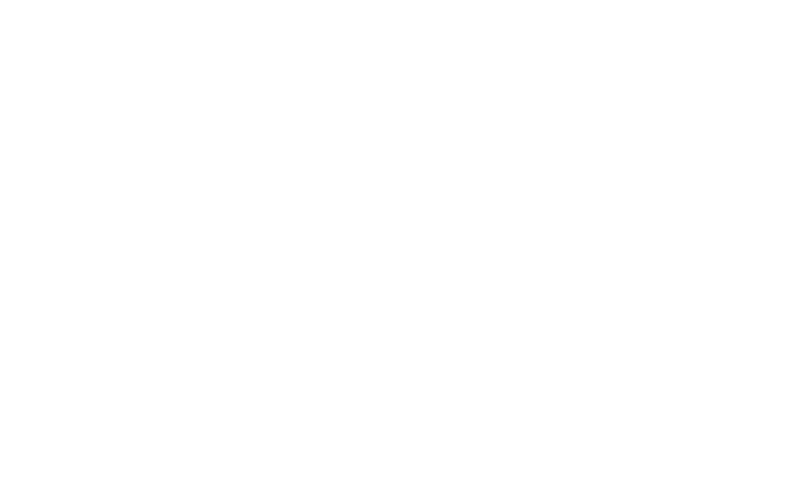

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(8,5), sharex=True, dpi=100)
ax = fig.gca()
axs[0,0].plot(ts/Pjup, Es[:,0], 'ko', ms=0.3)
axs[0,0].plot(ts/Pjup, a0+0*ts, 'k--', label='Analytic Solution')
axs[0,0].set_ylabel(r'$a$ (AU)', fontsize=14)
axs[0,0].legend(fontsize=12, loc=1)
axs[0,0].margins(0)
axs[0,1].plot(ts/Pjup, Es[:,1], 'ko', ms=0.3)
axs[0,1].plot(ts/Pjup, efilt, 'k-', ms=0.3, label='Mean Signal')
axs[0,1].plot(ts/Pjup, e_func(ts), 'k--', label='Analytic Solution')
axs[0,1].set_ylabel(r'$e$', fontsize=14)
axs[0,1].legend(fontsize=12)
axs[0,1].margins(0)
axs[1,0].plot(ts/Pjup, Es[:,2]*rad, 'ko', ms=0.3)
axs[1,0].plot(ts/Pjup, pomega_func(ts)*rad, 'k--', label='Analytic Solution');
axs[1,0].set_xlabel('Time (Jupiter Periods)', fontsize=14)
axs[1,0].set_ylabel(r'$\varpi$ (deg)', fontsize=14)
axs[1,0].legend(fontsize=12)
axs[1,0].margins(0)
axs[1,1].plot(ts/Pjup, Es[:,3]*rad, 'ko', ms=0.3)
axs[1,1].plot(ts/Pjup, Omega_func(ts)*rad, 'k--', label='Analytic Solution')
axs[1,1].set_xlabel('Time (Jupiter Periods)', fontsize=14)
axs[1,1].set_ylabel(r'$\Omega$ (deg)', fontsize=14)
axs[1,1].legend(fontsize=12)
axs[1,1].margins(0)
fig.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.21)
#plt.savefig('figs/orbital_elements.png',dpi=300)
plt.show()

In the previous figures we can see that up to second order in the excentricities, the analytical result fits well to the numerical simulation, where the main difference appears in the excentricity of the asteroid. This is is a very powerful result, because we've developed a powerful theory that can explain very complex systems. Up next we'll see how to upgrade this to higher body numer problems.

## **7.2 Secular Perturbations for Two Planets**

### Experiment: Laplace coefficients study (7.1)

In the previous section we introduced the computation of the Laplace coefficients and their derivatives (up to second order), who are completely essential in the development of perturbation theory. This functions are until now completely "dark" in a sense that we don't know how they behave or even how their derivatives behave. So, we´ll now show an interactive plot of $b_{s}^{(j)}(\alpha)$, $D \, b_{s}^{(j)}(\alpha)$ and $D^2 \, b_{s}^{(j)}(\alpha)$ where you can modify the parameters $s$ and $j$ to see how the coefficents change:

In [15]:
def blap_plot(s,j):
    a = np.linspace(0, 0.9, 1000)
    b = np.array([blap(x, s, j) for x in a])
    db = np.array([blap_dot(x, s, j) for x in a])
    ddb = np.array([blap_ddot(x, s, j) for x in a])
    
    j = int(j)
    s = str(Fraction(s).numerator) + '/' + str(Fraction(s).denominator)
    ss = fr'$s = {s}$' + r'$\hspace{20 pt}$' fr'$j = {j}$'
    
    plt.close()
    fig, axs = plt.subplots(3, 1, figsize=(4.5,7), sharex=True, dpi=110)
    axs[0].set_title(ss, fontsize=15)
    axs[0].set_ylabel(r'$b_{s}^{(j)}(\alpha)$', fontsize=17)
    axs[0].plot(a, b, 'k-')
    axs[1].set_xlabel(r'$\alpha$', fontsize=15)
    axs[1].set_ylabel(r'$D \, b_{s}^{(j)}(\alpha)$', fontsize=15)
    axs[1].plot(a, db, 'k-')
    axs[2].set_xlabel(r'$\alpha$', fontsize=15)
    axs[2].set_ylabel(r'$D^2 \, b_{s}^{(j)}(\alpha)$', fontsize=15)
    axs[2].plot(a, ddb, 'k-')
    fig.tight_layout()
    plt.subplots_adjust(hspace=0)
    plt.show()

In [40]:
opciones = dict(continuous_update=False)
interact(blap_plot,
         s = widgets.FloatSlider(min=0.5, max=5, step=0.5, value=0.5, **opciones),
         j = widgets.FloatSlider(min=0, max=5, step=1, value=0, **opciones))

interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='s', max=5.0, min=0.5, step=…

<function __main__.blap_plot(s, j)>

An important result of the previous plots is that the Laplace coefficients diverge rapidly near $\alpha = 1$, and so their derivatives. You can also check that if you increase the value of the $s$ parameter, the coefficient is virtually cero for a large number of $\alpha$ values, and diverge much quickly near $\alpha=1$. Be free to combine dfferent parameter values to check all of this for yourself.

### Experiment: excentricity and inclination vectors (7.2)

<IPython.core.display.Javascript object>


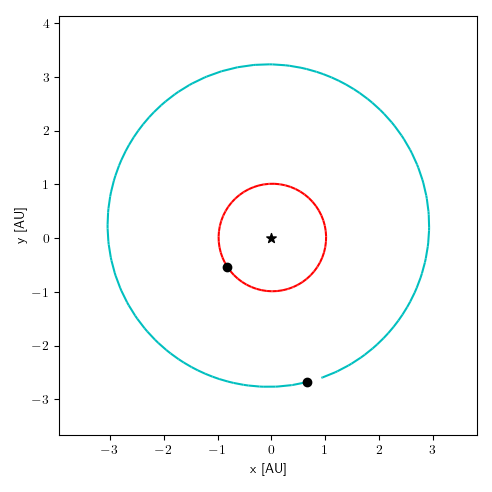

In [47]:
#Partticle #1
a1 = 1
e1 = 0.02
pomega1 = 10

#Particle #2
a2 = 3
e2 = 0.08
pomega2 = 250

#Smulation t=0
sim = rb.Simulation()
sim.units = ('au', 'msun', 'yr')
sim.add(m=1e7, hash='Sun')
sim.add(m=1, a=a1, e=e1, pomega=pomega1, hash='Particle #1')
sim.add(m=1, a=a2, e=e2, pomega=pomega2, hash='Particle #2')
#sim.save('tmp/system.bin')

#Orbits plot
fig, ax = rb.OrbitPlot(sim, unitlabel='[AU]', orbit_type='solid', lw=1.5, color=True)
fig.set_dpi(100)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


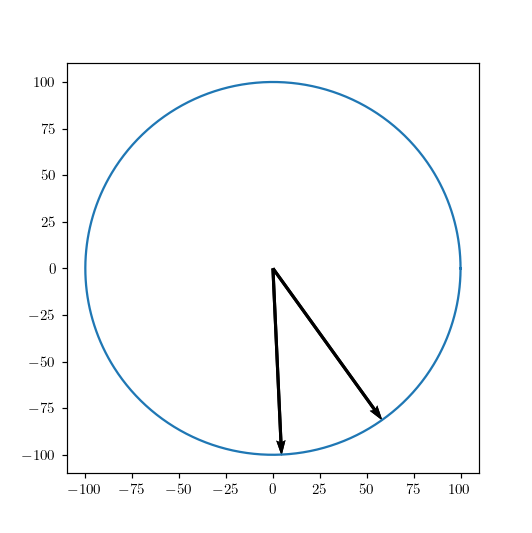

In [48]:
theta = np.linspace(0, 2*np.pi, 1000)

hvec = np.zeros(2)
kvec = np.zeros(2)

hvec[0] = e1*np.sin(deg*pomega1)
hvec[1] = e2*np.sin(deg*pomega2)

k[0] = e1*np.cos(deg*pomega1)
k[1] = e2*np.cos(deg*pomega2)

hvec = np.array([hvec])/np.sqrt(h.dot(h))
kvec = np.array([kvec])/np.sqrt(k.dot(k))

origin = np.array([[0,0],[0,0]])

L = 100

fig = plt.figure(dpi=110, figsize=(5,5))
plt.xlim(-1.1*L,1.1*L)
plt.ylim(-1.1*L,1.1*L)
plt.quiver(*origin, h[:,0], h[:,1], scale_units='x', scale=1/L)
plt.quiver(*origin, k[:,0], k[:,1], scale_units='x', scale=1/L)
plt.plot(L*np.cos(theta), L*np.sin(theta))
plt.show()